# Sex prediction 

Final jupyter notebook for sex prediction using infrared spectroscopy data from heads and thorax 

## Changelog

### 2023-11-04

#### Modified

- Remove 3 days old females from data sets
- Redo plots with new dataset
- It is ready



In [1]:
%load_ext autoreload
%autoreload 2

In [44]:

import sys

import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model

from utilities import model_optimization
from utilities import variable_importance_df



In [2]:
colors = sn.color_palette("Set2") 

In [3]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldatasetclean.csv", sep=',')

In [4]:
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
tsetse_data_sameages = tsetse_data_copy[(tsetse_data_copy["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

In [7]:
df_ic = pd.DataFrame(tsetse_data_sameages_copy.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue      
f   5w  Abdomen   16
        Head      92
        Thorax    96
    7w  Abdomen   38
        Head     120
        Thorax   122
m   5w  Head      94
        Thorax    93
    7w  Abdomen   15
        Head      93
        Thorax    92

## Sex prediction

In [8]:
tsetse_thorax = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Head']

In [9]:
tsetse_head.groupby("Sex")["ID"].count()

Sex
f    212
m    187
Name: ID, dtype: int64

In [81]:
X_thorax = tsetse_thorax.loc[:,"1750":"602"]
y_thorax = tsetse_thorax.loc[:,"Sex"]

X_head = tsetse_head.loc[:,"1750":"602"]
y_head = tsetse_head.loc[:,"Sex"]

In [82]:
wnLabels= X_thorax.columns.values.tolist() #wavenumbers labels
waveNums = [int(x) for x in wnLabels] #wavenumbers numbers (for plotting)

In [83]:
# Split tain and test

X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [72]:
shape_sets = {"training set head": y_hd_train.value_counts(),
              "Test set head": y_hd_test.value_counts(),
              "training set thorax": y_th_train.value_counts(),
              "test set thorax": y_th_test.value_counts()}

In [14]:
shape_sets_sex = pd.DataFrame(shape_sets,index=['f','m'])

shape_sets_sex

,training set head,Test set head,training set thorax,test set thorax
f,166,46,166,52
m,153,34,156,29


In [84]:
# baseline accuracy for head and thorax

thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [85]:
data_plot_thorax = dataplotmelt(thorax_acc_baseline)
data_plot_head = dataplotmelt(head_acc_baseline)

In [86]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.896875  0.048412
1        LR  0.935937  0.023811
2        RF  0.925000  0.030190
3       SVC  0.932813  0.033794


In [87]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.847692  0.046692
1        LR  0.924615  0.023444
2        RF  0.873846  0.036117
3       SVC  0.866154  0.031654


In [88]:
# optimization

bestmodel_head = model_optimization(X_hd_train,y_hd_train)
bestmodel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [89]:
# test head and thorax

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, bestmodel_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, bestmodel_thorax)

In [90]:
# final accuracy head and thorax on test set

accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9625
Accuracy on test set: 0.9012345679012346


In [22]:
# classification report head

report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head["Tissue"] = "Head"

In [23]:
# classification report thorax

report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax["Tissue"] = "Thorax"

In [25]:
report_sex_informative = pd.concat([report_head, report_thorax])

report_sex_informative.to_excel("../results/tables/informative_region_results/report_sex_informative.xlsx")

In [91]:
top20_head = variable_importance_df(waveNums, bestmodel_head)
top20_thorax = variable_importance_df(waveNums, bestmodel_thorax)

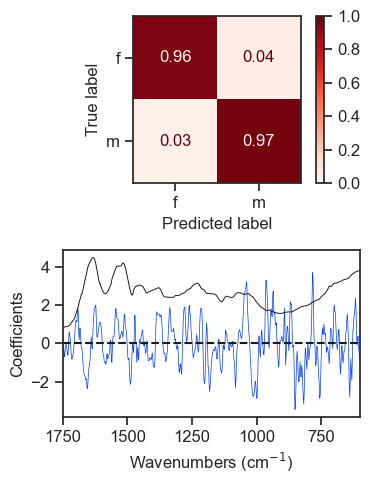

In [93]:
# Final plot paper
# confusion matrix for head and model coefficients

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )
fig, (ax, ax2) = plt.subplots(2,1, figsize=(4,5), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=waveNums,y=bestmodel_head['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)

sn.lineplot(x=waveNums, y=(np.mean(X_head ,axis=0)*15),color='k',ax=ax2, linewidth=0.7)


ax2.set_xlim(1750,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.axhline(0, ls="--",color='k')

plt.savefig("../results/plots/Fig5_sex_heaD_informative.tiff", dpi=300)


In [94]:
top20_head = variable_importance_df(waveNums, bestmodel_head)

top20_head

,Wavenumbers,Coefficients
483,784,3.710773
484,782,3.423736
393,964,3.321376
355,1040,3.240587
394,962,3.159427
356,1038,3.073179
354,1042,2.891044
353,1044,2.857033
407,936,2.747279
395,960,2.665635


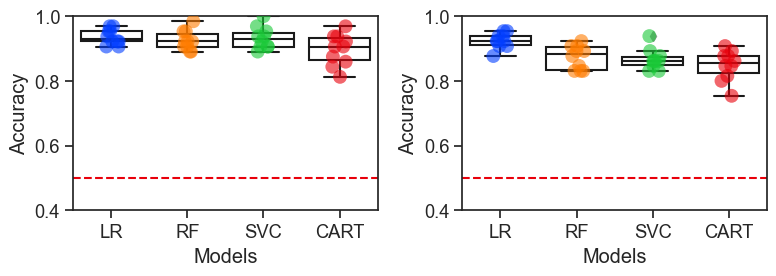

In [95]:
# Final plot suplementary
# here will be training resuslts for head and thorax
# test set results for thorax (confusion matrix) and coefficients

# final model
# settings

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax,ax2)) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

#boxplots
sn.boxplot(data_plot_head,x='param_clf', y='value', ax=ax,color='white')
sn.stripplot(data_plot_head,x='param_clf', y='value',ax=ax, alpha=0.6, hue='param_clf',legend=False,size=10)

sn.boxplot(data_plot_thorax,x='param_clf', y='value', color='white', ax=ax2)
sn.stripplot(data_plot_thorax, x='param_clf', y='value',hue='param_clf', size=10, alpha=0.6, ax=ax2, legend=False)

plt.setp(ax.lines, color='k')
plt.setp(ax2.lines, color='k')

for i, box in enumerate(ax.patches):
    box.set_edgecolor(color='k')

for i, box in enumerate(ax2.patches):
    box.set_edgecolor(color='k')

axes1 = [ax,ax2]
for i in axes1:
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")
    i.axhline(0.5, ls="--",color='r')

plt.savefig("../results/plots/sex_prediction_training_informative_suplementary.tiff", dpi=300)


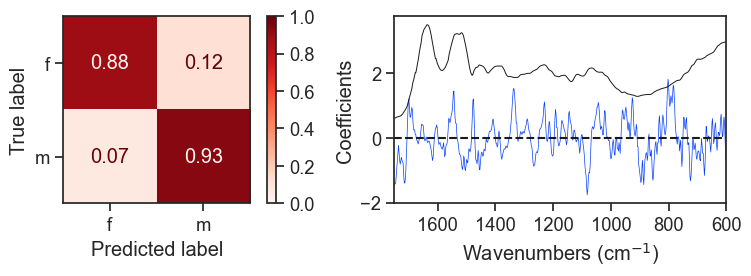

In [99]:
# Final plot paper
# confusion matrix for head and model coefficients

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=waveNums,y=bestmodel_thorax['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)

sn.lineplot(x=waveNums, y=(np.mean(X_thorax ,axis=0)*12),color='k',ax=ax2, linewidth=0.7)


ax2.set_xlim(1750,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.axhline(0, ls="--",color='k')

plt.savefig("../results/plots/sex_prediction_thorax_suplementary.tiff", dpi=300)